In [1]:
#Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import optimizers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K  

In [2]:
#Load numpy arrays
training_inputs = np.load('training_inputs.npy')
training_ground_truth = np.load('training_ground_truth.npy')
testing_inputs = np.load('testing_inputs.npy')
testing_ground_truth = np.load('testing_ground_truth.npy')

input_shape = training_inputs.shape

In [ ]:
#Data augmentation
def augment_2d(inputs, rotation=0, horizontal_flip=False, vertical_flip=False, deform=False):
    """Apply additive augmentation on 2D data.

    # Arguments
      rotation: A float, the degree range for rotation (0 <= rotation < 180),
          e.g. 3 for random image rotation between (-3.0, 3.0).
      horizontal_flip: A boolean, whether to allow random horizontal flip,
          e.g. true for 50% possibility to flip image horizontally.
      vertical_flip: A boolean, whether to allow random vertical flip,
          e.g. true for 50% possibility to flip image vertically.

    # Returns
      input data after augmentation, whose shape is the same as its original.
    """
    if inputs.dtype != tf.float32:
        inputs = tf.image.convert_image_dtype(inputs, dtype=tf.float32)

    with tf.name_scope('augmentation'):
        shp = tf.shape(inputs)
        batch_size, channels, height, width = shp[0], shp[1], shp[2], shp[3]
        width = tf.cast(width, tf.float32)
        height = tf.cast(height, tf.float32)

        transforms = []
        identity = tf.constant([1, 0, 0, 0, 1, 0, 0, 0], dtype=tf.float32)

        if rotation > 0:
            angle_rad = rotation * 3.141592653589793 / 180.0
            angles = tf.random_uniform([batch_size], -angle_rad, angle_rad)
            f = tf.contrib.image.angles_to_projective_transforms(angles,
                                                                 height, width)
            transforms.append(f)

        if horizontal_flip:
            coin = tf.less(tf.random_uniform([batch_size], 0, 1.0), 0.5)
            shape = [-1., 0., width, 0., 1., 0., 0., 0.]
            flip_transform = tf.convert_to_tensor(shape, dtype=tf.float32)
            flip = tf.tile(tf.expand_dims(flip_transform, 0), [batch_size, 1])
            noflip = tf.tile(tf.expand_dims(identity, 0), [batch_size, 1])
            transforms.append(tf.where(coin, flip, noflip))

        if vertical_flip:
            coin = tf.less(tf.random_uniform([batch_size], 0, 1.0), 0.5)
            shape = [1., 0., 0., 0., -1., height, 0., 0.]
            flip_transform = tf.convert_to_tensor(shape, dtype=tf.float32)
            flip = tf.tile(tf.expand_dims(flip_transform, 0), [batch_size, 1])
            noflip = tf.tile(tf.expand_dims(identity, 0), [batch_size, 1])
            transforms.append(tf.where(coin, flip, noflip))
    '''
        deformations are not natively implemented in tensorflow, I'll do the easy ones first
        if deform:
            random_state = np.random.RandomState(None)
            shape = image.shape
            dx = gaussian_filter((random_state.rand(*shape)*2 - 1), sigma, mode = "constant",cval = 0)*alpha
            dy = gaussian_filter((random_state.rand(*shape)*2 - 1), sigma, mode = "constant",cval = 0)*alpha
            x,y = np.meshgrid(np.arange(shape[1]),np.arange(shape[0]))
            indices = np.reshape(y+dy,(-1,1)), np.reshape(x+dx,(-1,1))
            distorted_image = map_coordinates(image,indices,order=1,mode='reflect')
    '''
    if transforms:
        f = tf.contrib.image.compose_transforms(*transforms)
        inputs = tf.contrib.image.transform(inputs, f, interpolation='BILINEAR')
    return inputs

In [3]:
def conv_block(input_tensor, num_filters):
  encoder = layers.Conv2D(filters=num_filters, 
                          kernel_size=(3, 3), 
                          padding='same',
                          data_format='channels_last')(input_tensor)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(encoder)
  
  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(filters=num_filters, 
                                   kernel_size=(2, 2), 
                                   strides=(2, 2), 
                                   padding='same',
                                   data_format='channels_last')(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  return decoder

In [4]:
inputs = layers.Input(shape = input_shape[1:])
# 256

encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128

encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64

encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32

encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16

encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8

center = conv_block(encoder4_pool, 1024)
# center

decoder4 = decoder_block(center, encoder4, 512)
# 16

decoder3 = decoder_block(decoder4, encoder3, 256)
# 32

decoder2 = decoder_block(decoder3, encoder2, 128)
# 64

decoder1 = decoder_block(decoder2, encoder1, 64)
# 128

decoder0 = decoder_block(decoder1, encoder0, 32)
# 256

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

W0918 21:27:11.645547  4816 deprecation.py:506] From C:\Users\Malec\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [5]:
model = models.Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 768, 1024, 1 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 768, 1024, 32 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 768, 1024, 32 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 768, 1024, 32 0           batch_normalization[0][0]        
______________________________________________________________________________________________

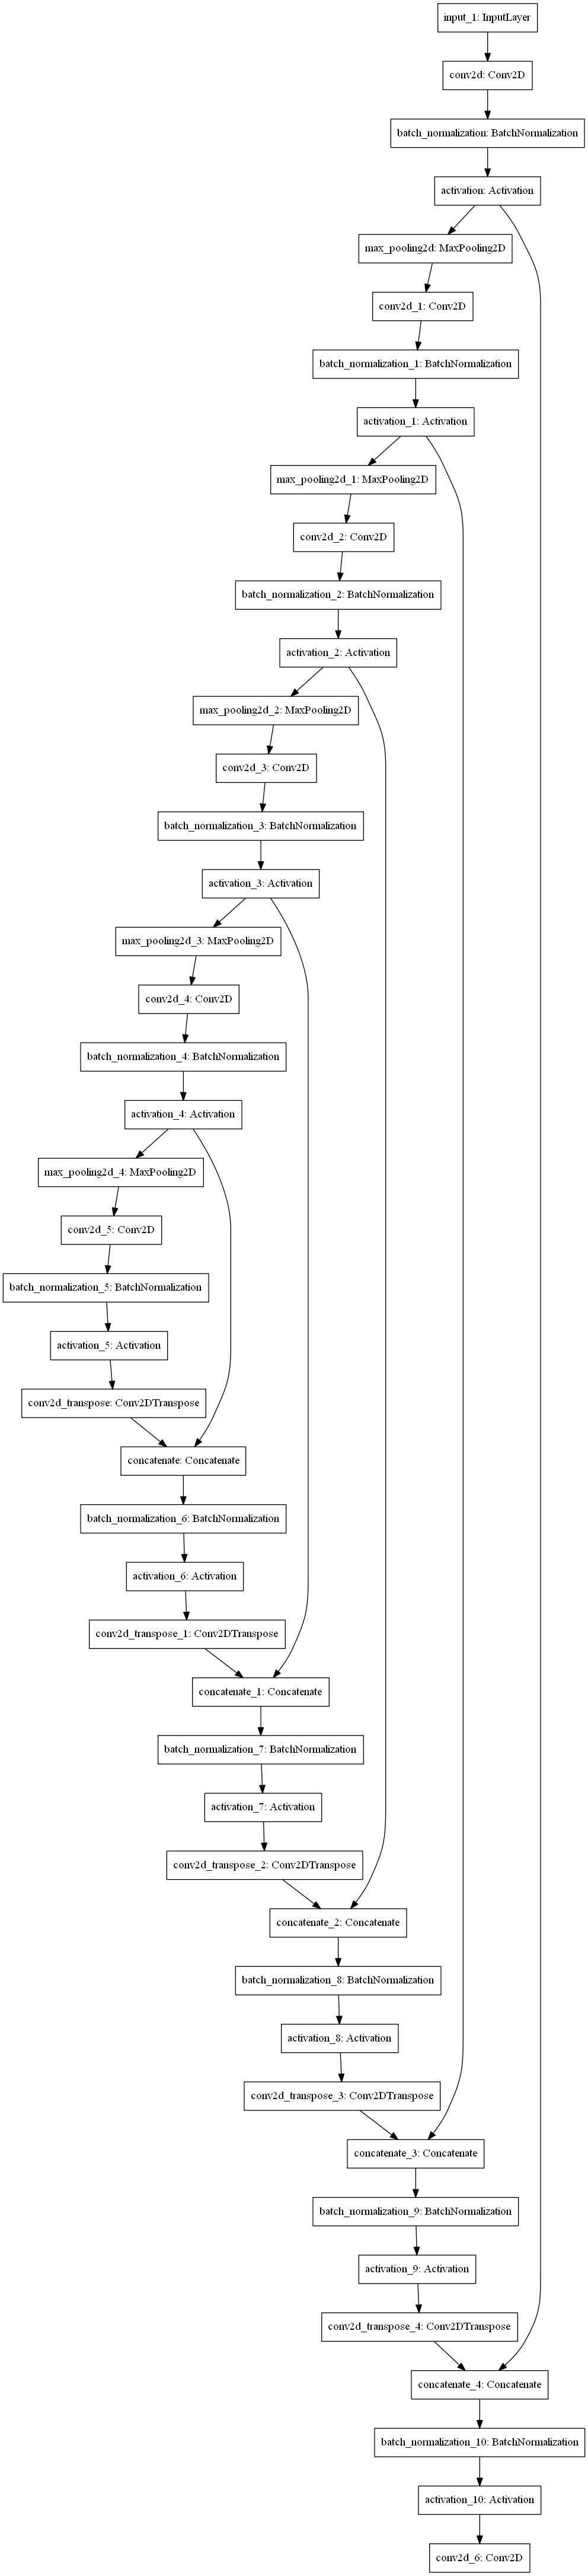

In [6]:
from tensorflow.keras.utils import plot_model

plot_model(model,to_file = 'model_plot.png',rankdir='TB')

In [7]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [8]:
model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_loss])

In [9]:
training_inputs /= 255
training_ground_truth /= 255
testing_ground_truth /= 255
testing_inputs /= 255

In [10]:
validation_inputs = testing_inputs[:20,:,:,:]
validation_ground_truth = testing_ground_truth[:20,:,:,:]

In [50]:
#Initiate Adam optimizer with default values
opt = optimizers.Adam()

#Compile model
model.compile(optimizer=opt, 
              loss=dice_loss, 
              metrics=[dice_coeff])

#Some parameters
batch_size = 5
epochs = 5

#Define a model callback
save_model_path = 'tmp/weights.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, 
                                        monitor='val_loss',
                                        save_best_only=True, 
                                        verbose=1)
#Fit the model
history = model.fit(training_inputs, 
                    training_ground_truth,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(validation_inputs, validation_ground_truth),
                    shuffle=True,
                    callbacks=[cp]
                   )

Train on 165 samples, validate on 20 samples
Epoch 1/5
160/165 [============================>.] - ETA: 11:23 - loss: 0.6331 - dice_coeff: 0.3669
Epoch 00001: val_loss improved from inf to 0.86093, saving model to tmp/weights.hdf5
165/165 [==============================] - 22640s 137s/sample - loss: 0.6282 - dice_coeff: 0.3718 - val_loss: 0.8609 - val_dice_coeff: 0.1391
Epoch 2/5
160/165 [============================>.] - ETA: 9:44 - loss: 0.3925 - dice_coeff: 0.6075 
Epoch 00002: val_loss did not improve from 0.86093
165/165 [==============================] - 19564s 119s/sample - loss: 0.3887 - dice_coeff: 0.6113 - val_loss: 0.8703 - val_dice_coeff: 0.1297
Epoch 3/5
160/165 [============================>.] - ETA: 10:04 - loss: 0.2108 - dice_coeff: 0.7892
Epoch 00003: val_loss did not improve from 0.86093
165/165 [==============================] - 20274s 123s/sample - loss: 0.2093 - dice_coeff: 0.7907 - val_loss: 0.8953 - val_dice_coeff: 0.1047
Epoch 4/5
160/165 [=======================

In [51]:
# Score trained model.
test_indices = np.random.choice(range(165),5,replace=False)
scores = model.evaluate(testing_inputs[test_indices,:,:,:], 
                        testing_ground_truth[test_indices,:,:,:], 
                        verbose=1)

print('Test loss:', scores[0])

5/5 [==============================] - 6s 1s/sample - loss: 0.9744 - dice_coeff: 0.0256
Test loss: 0.9743524193763733


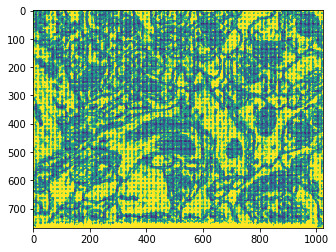

In [98]:
predict_mask = model.predict(training_inputs[:5,:,:])[0][:,:,0]
plt.imshow(predict_mask,vmin = np.min(predict_mask),vmax=2*np.min(predict_mask))
plt.show()

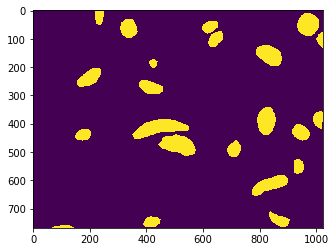

In [96]:
plt.imshow(training_ground_truth[0,:,:,0])
plt.show()